### Installing Tensorflow 1.9.0

In [ ]:
#!conda install tensorflow==1.9.0 -y

# Introduction

TensorFlow is an open source library for numerical computation, specializing in machine learning applications.

What you will build
In this codelab, you will learn how to run TensorFlow on a single machine, and will train a simple classifier to classify images of flowers.

![alt text](https://codelabs.developers.google.com/codelabs/tensorflow-for-poets/img/3021186b83bc90c2.png "Image CC-BY by Retinafunk")



- daisy (score = 0.99071)
- sunflowers (score = 0.00595)
- dandelion (score = 0.00252)
- roses (score = 0.00049)
- tulips (score = 0.00032)

We will be using transfer learning, which means we are starting with a model that has been already trained on another problem. We will then retrain it for our specific problem. Deep learning from scratch can take days, but transfer learning can be done in short order. Transfer learning builds on the fact that a model first layers learn low-level features such as edges that are common to most images, whatever the objects inside. The model last layers represent the high-level features which characterize the objects in the image and only them need to be re-trained.

We are going to use a model trained on the ImageNet Large Visual Recognition Challenge dataset. This model can differentiate between 1,000 different classes, like Dalmatian or dishwasher. You will have a choice of model architectures (several hyper-parameters), so you can determine the right tradeoff between speed, size and accuracy for your problem.

We will use this same model in this exercise, but we will retrain it to tell apart a small number of classes based on our own examples.

Finally, we are going to deploy this model for inference using the OpenVINO toolkit and observe the acceleration provided by this tool compared to inference via Tensorflow. 

What you'll learn:
- How to use Python and TensorFlow to train an image classifier
- How to classify images with your trained classifier
- How to prepare your model for inference through OpenVINO 
- How to deploy your model for inference with OpenVINO

What you need:
- A basic understanding of Linux commands

## Clone the git repository
All the code used in this codelab is contained in this git repository. Clone the repository and cd into it. This is where we will be working.

In [1]:
%rmdir -rf tensorflow-for-poets-2

The system cannot find the file specified.
The system cannot find the file specified.


In [2]:
!git clone https://github.com/googlecodelabs/tensorflow-for-poets-2

Cloning into 'tensorflow-for-poets-2'...


In [3]:
%cd tensorflow-for-poets-2
!dir

C:\Users\NUC8i7\Desktop\EWDemo\tensorflow-for-poets-2
 Volume in drive C has no label.
 Volume Serial Number is 0452-E512

 Directory of C:\Users\NUC8i7\Desktop\EWDemo\tensorflow-for-poets-2

02/22/2019  01:59 PM    <DIR>          .
02/22/2019  01:59 PM    <DIR>          ..
02/22/2019  01:59 PM               110 .gitignore
02/22/2019  01:59 PM    <DIR>          android
02/22/2019  01:59 PM               992 CONTRIBUTING.md
02/22/2019  01:59 PM    <DIR>          ios
02/22/2019  01:59 PM            11,558 LICENSE
02/22/2019  01:59 PM             1,393 README.md
02/22/2019  01:59 PM    <DIR>          scripts
02/22/2019  01:59 PM    <DIR>          tf_files
               4 File(s)         14,053 bytes
               6 Dir(s)  102,682,574,848 bytes free


## Download the training images

Before you start any training, you'll need a set of images to teach the model about the new classes you want to recognize. We've created an archive of creative-commons licensed flower photos to use initially. Download the photos (218 MB) by invoking the following two commands:

In [4]:
import urllib.request
    
url = "http://download.tensorflow.org/example_images/flower_photos.tgz"
fileName = "flower_photos.tgz"
urllib.request.urlretrieve(url, fileName)
print("Downloaded")


Downloaded


In [5]:
!start "" "%PROGRAMFILES%\Git\bin\sh.exe" --login

#In the git bash, execute the following commands without # symbol
#tar -xzf flower_photos.tgz
#mv flower_photos tf_files

You should now have a copy of the flower photos. Confirm the contents of your working directory by issuing the following command:

In [6]:
!dir tf_files\flower_photos

 Volume in drive C has no label.
 Volume Serial Number is 0452-E512

 Directory of C:\Users\NUC8i7\Desktop\EWDemo\tensorflow-for-poets-2\tf_files\flower_photos

02/11/2016  02:22 AM    <DIR>          .
02/11/2016  02:22 AM    <DIR>          ..
02/11/2016  02:22 AM    <DIR>          daisy
02/11/2016  02:22 AM    <DIR>          dandelion
02/09/2016  08:29 AM           418,049 LICENSE.txt
02/11/2016  02:22 AM    <DIR>          roses
02/11/2016  02:22 AM    <DIR>          sunflowers
02/11/2016  02:22 AM    <DIR>          tulips
               1 File(s)        418,049 bytes
               7 Dir(s)  102,178,885,632 bytes free


# Retraining the network

Configure your MobileNet
In this exercise, we will retrain a MobileNet. MobileNet is a a small efficient convolutional neural network. "Convolutional" just means that the same calculations are performed at each location in the image.

The MobileNet is configurable in two ways:

Input image resolution: 128,160,192, or 224px. Unsurprisingly, feeding in a higher resolution image takes more processing time, but results in better classification accuracy.
The relative size of the model as a fraction of the largest MobileNet: 1.0, 0.75, 0.50, or 0.25.
We will use 224 and 0.5 for this codelab.

## Run the re-training
As noted in the introduction, ImageNet models are networks with millions of parameters that can differentiate a large number of classes. We're only training the final layer of that network, so training will end in a reasonable amount of time.

Start your retraining with one big command (note the --summaries_dir option, sending training progress reports to the directory that tensorboard is monitoring). First, run the command tensorboard described when running the cell below from another shell. You will see the training progress at the adress: http://localhost:6006

In [ ]:
#Remove # and run the following command in separate command prompt
#tensorboard --logdir=tf_files/training_summaries/flower_photos/mobilenet_0.50_224/train

In [7]:
!start "" cmd /K python -m scripts.retrain --bottleneck_dir=tf_files/bottlenecks/flower_photos --how_many_training_steps=100 --model_dir=tf_files/models/ --summaries_dir="tf_files/training_summaries/flower_photos/mobilenet_0.50_224" --output_graph=tf_files/retrained_graph.pb --output_labels=tf_files/retrained_labels.txt --architecture="mobilenet_0.50_224" --image_dir=tf_files/flower_photos


## Classifying an image (inference with TensorFlow)
The codelab repo also contains a copy of tensorflow's label_image.py example, which you can use to test your network. Take a minute to read the help for this script:

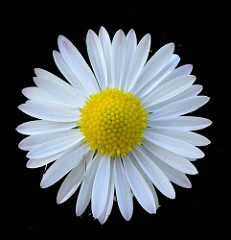

In [8]:
daisy_image='tf_files/flower_photos/daisy/21652746_cc379e0eea_m.jpg'
from PIL import Image
Image.open(daisy_image)

In [9]:
!python -m scripts.label_image --graph=tf_files/retrained_graph.pb --image=tf_files/flower_photos/daisy/21652746_cc379e0eea_m.jpg


Evaluation time (1-image): 0.301s

daisy (score=0.97443)
sunflowers (score=0.02219)
dandelion (score=0.00269)
roses (score=0.00069)
tulips (score=0.00000)


2019-02-22 14:03:04.265255: I tensorflow/core/platform/cpu_feature_guard.cc:141] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX AVX2
2019-02-22 14:03:04.267108: I tensorflow/core/common_runtime/process_util.cc:69] Creating new thread pool with default inter op setting: 8. Tune using inter_op_parallelism_threads for best performance.


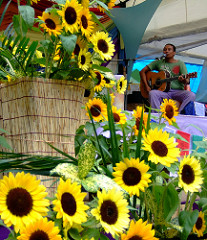

In [10]:
sunflower_image='tf_files/flower_photos/sunflowers/969913643_9d5cd2fe45_m.jpg'
Image.open(sunflower_image)

In [11]:
!python -m scripts.label_image --graph=tf_files/retrained_graph.pb --image=tf_files/flower_photos/sunflowers/969913643_9d5cd2fe45_m.jpg


Evaluation time (1-image): 0.306s

sunflowers (score=0.99974)
dandelion (score=0.00018)
roses (score=0.00006)
tulips (score=0.00002)
daisy (score=0.00000)


2019-02-22 14:03:19.247602: I tensorflow/core/platform/cpu_feature_guard.cc:141] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX AVX2
2019-02-22 14:03:19.249351: I tensorflow/core/common_runtime/process_util.cc:69] Creating new thread pool with default inter op setting: 8. Tune using inter_op_parallelism_threads for best performance.


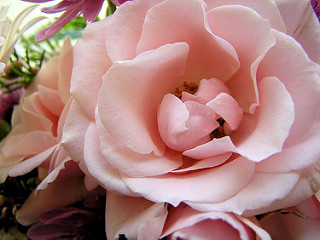

In [12]:
rose_image='tf_files/flower_photos/roses/12240303_80d87f77a3_n.jpg'
Image.open(rose_image)

In [13]:
!python -m scripts.label_image --graph=tf_files/retrained_graph.pb --image=tf_files/flower_photos/roses/12240303_80d87f77a3_n.jpg


Evaluation time (1-image): 0.301s

roses (score=0.99999)
sunflowers (score=0.00000)
daisy (score=0.00000)
dandelion (score=0.00000)
tulips (score=0.00000)


2019-02-22 14:03:35.468283: I tensorflow/core/platform/cpu_feature_guard.cc:141] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX AVX2
2019-02-22 14:03:35.470442: I tensorflow/core/common_runtime/process_util.cc:69] Creating new thread pool with default inter op setting: 8. Tune using inter_op_parallelism_threads for best performance.


Take a look at the inference times with Tensorflow. We will compare them later with OpenVINO inference time.

In [14]:
!copy tf_files\retrained_graph.pb tf_files\dataset1_retrained_graph.pb
!copy tf_files\retrained_labels.txt tf_files\dataset1_retrained_labels.txt

        1 file(s) copied.
        1 file(s) copied.


# Running OpenVino on local machine (with computer_vision_sdk_2018.5.*)

## Source the environement variables (path to OpenCV and Python) and installation of prerequisites

In [15]:
!C:\Intel\computer_vision_sdk\bin\setupvars.bat

ECHO is off.
PYTHONPATH=C:\Intel\computer_vision_sdk\python\python3.6;C:\Intel\computer_vision_sdk\python\python3.6;
[setupvars.bat] OpenVINO environment initialized


In [ ]:
#install TF prerequisites through another Anaconda prompt with python 3.6 environment activated (execute following commands without #)
#cd C:\Intel\computer_vision_sdk\deployment_tools\model_optimizer
#conda install --file requirements_tf.txt -y

## Run the Model Optimizer on the first re-trained model (no sunflower model)

In [16]:
# Run dataset1 (sunflowers will get low values)

!copy tf_files\dataset1_retrained_labels.txt tf_files\dataset1_retrained_graph.labels
!python C:\Intel\computer_vision_sdk\deployment_tools\model_optimizer\mo_tf.py --input_model tf_files/dataset1_retrained_graph.pb --output_dir tf_files --mean_values [128,128,128] --scale_values [224,224,224]

        1 file(s) copied.
Model Optimizer arguments:
Common parameters:
	- Path to the Input Model: 	C:\Users\NUC8i7\Desktop\EWDemo\tensorflow-for-poets-2\tf_files/dataset1_retrained_graph.pb
	- Path for generated IR: 	C:\Users\NUC8i7\Desktop\EWDemo\tensorflow-for-poets-2\tf_files
	- IR output name: 	dataset1_retrained_graph
	- Log level: 	ERROR
	- Batch: 	Not specified, inherited from the model
	- Input layers: 	Not specified, inherited from the model
	- Output layers: 	Not specified, inherited from the model
	- Input shapes: 	Not specified, inherited from the model
	- Mean values: 	[128,128,128]
	- Scale values: 	[224,224,224]
	- Scale factor: 	Not specified
	- Precision of IR: 	FP32
	- Enable fusing: 	True
	- Enable grouped convolutions fusing: 	True
	- Move mean values to preprocess section: 	False
	- Reverse input channels: 	False
TensorFlow specific parameters:
	- Input model in text protobuf format: 	False
	- Offload unsupported operations: 	False
	- Path to model dump for Tenso

## Run OpenVINO classification sample with re-trained model on flower pictures

In [17]:
!C:\Intel\computer_vision_sdk\bin\setupvars.bat""
!%HOMEPATH%\Documents\Intel\OpenVINO\inference_engine_samples_2017\intel64\Debug\classification_sample.exe -i tf_files\flower_photos\daisy\21652746_cc379e0eea_m.jpg -m tf_files\dataset1_retrained_graph.xml
!%HOMEPATH%\Documents\Intel\OpenVINO\inference_engine_samples_2017\intel64\Debug\classification_sample.exe -i tf_files\flower_photos\sunflowers\969913643_9d5cd2fe45_m.jpg -m tf_files\dataset1_retrained_graph.xml
!%HOMEPATH%\Documents\Intel\OpenVINO\inference_engine_samples_2017\intel64\Debug\classification_sample.exe -i tf_files\flower_photos\roses\12240303_80d87f77a3_n.jpg -m tf_files\dataset1_retrained_graph.xml

ECHO is off.
PYTHONPATH=C:\Intel\computer_vision_sdk\python\python3.6;C:\Intel\computer_vision_sdk\python\python3.6;
[setupvars.bat] OpenVINO environment initialized
[ INFO ] InferenceEngine: 
	API version ............ 1.4
	Build .................. 19154
[ INFO ] Parsing input parameters
[ INFO ] Files were added: 1
[ INFO ]     tf_files\flower_photos\daisy\21652746_cc379e0eea_m.jpg
[ INFO ] Loading plugin

	API version ............ 1.5
	Build .................. win_20181005
	Description ....... MKLDNNPlugin
[ INFO ] Loading network files:
	tf_files\dataset1_retrained_graph.xml
	tf_files\dataset1_retrained_graph.bin
[ INFO ] Preparing input blobs
[ WARNING ] Image is resized from (231, 240) to (224, 224)
[ INFO ] Batch size is 1
[ INFO ] Preparing output blobs
[ INFO ] Loading model to the plugin
name: input [ out: U8/l=NCHW ]
name: input_U8_FP32_Mul_/Fused_Mul_/FusedScaleShift_ [ in: U8/l=NCHW; out: FP32/l=NCHW ]
name: Mul_/Fused_Mul_/FusedScaleShift_ [ in: FP32/l=NCHW; out: FP32/l=NC

[ INFO ] InferenceEngine: 
	API version ............ 1.4
	Build .................. 19154
[ INFO ] Parsing input parameters
[ INFO ] Files were added: 1
[ INFO ]     tf_files\flower_photos\roses\12240303_80d87f77a3_n.jpg
[ INFO ] Loading plugin

	API version ............ 1.5
	Build .................. win_20181005
	Description ....... MKLDNNPlugin
[ INFO ] Loading network files:
	tf_files\dataset1_retrained_graph.xml
	tf_files\dataset1_retrained_graph.bin
[ INFO ] Preparing input blobs
[ WARNING ] Image is resized from (320, 240) to (224, 224)
[ INFO ] Batch size is 1
[ INFO ] Preparing output blobs
[ INFO ] Loading model to the plugin
name: input [ out: U8/l=NCHW ]
name: input_U8_FP32_Mul_/Fused_Mul_/FusedScaleShift_ [ in: U8/l=NCHW; out: FP32/l=NCHW ]
name: Mul_/Fused_Mul_/FusedScaleShift_ [ in: FP32/l=NCHW; out: FP32/l=NCHW ]
name: MobilenetV1/MobilenetV1/Conv2d_0/convolution [ in: FP32/l=NCHW; out: FP32/l=BLOCKED ]
name: MobilenetV1/MobilenetV1/Conv2d_1_depthwise/depthwise [ in: FP32

Look at the inference times with OpenVINO compared to the Tensorflow inferences, you should be able to see an important acceleration. Both inferences are happening on CPU

We will now run the inference on the Movidius stick. 

For Intel® Movidius™ Neural Compute Stick and Intel® Neural Compute Stick 2, the OpenVINO™ toolkit provides the Movidius™ VSC driver. To install the driver:

1. Go to the <INSTALL_DIR>\deployment_tools\inference-engine\external\ directory, where <INSTALL_DIR> is the directory in which the Intel Distribution of OpenVINO toolkit is installed.

2. Right click on the Movidius_VSC_Device.inf file and choose Install from the pop up menu:

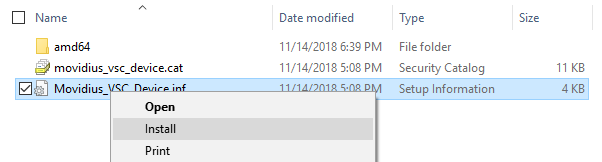

You have installed the driver for your Intel® Movidius™ Neural Compute Stick or Intel® Neural Compute Stick 2.

Now, we need to get the Intermediate Representation in Floating Point 16.

In [19]:
# Run dataset1 (sunflowers will get low values)
%env TRAIN_DB_NAME=dataset1

!python C:\Intel\computer_vision_sdk\deployment_tools\model_optimizer\mo_tf.py --input_model tf_files/dataset1_retrained_graph.pb --data_type FP16 --output_dir tf_files --mean_values [128,128,128] --scale_values [224,224,224]

env: TRAIN_DB_NAME=dataset1
Model Optimizer arguments:
Common parameters:
	- Path to the Input Model: 	C:\Users\NUC8i7\Desktop\EWDemo\tensorflow-for-poets-2\tf_files/dataset1_retrained_graph.pb
	- Path for generated IR: 	C:\Users\NUC8i7\Desktop\EWDemo\tensorflow-for-poets-2\tf_files
	- IR output name: 	dataset1_retrained_graph
	- Log level: 	ERROR
	- Batch: 	Not specified, inherited from the model
	- Input layers: 	Not specified, inherited from the model
	- Output layers: 	Not specified, inherited from the model
	- Input shapes: 	Not specified, inherited from the model
	- Mean values: 	[128,128,128]
	- Scale values: 	[224,224,224]
	- Scale factor: 	Not specified
	- Precision of IR: 	FP16
	- Enable fusing: 	True
	- Enable grouped convolutions fusing: 	True
	- Move mean values to preprocess section: 	False
	- Reverse input channels: 	False
TensorFlow specific parameters:
	- Input model in text protobuf format: 	False
	- Offload unsupported operations: 	False
	- Path to model dump for Ten

In [20]:
!C:\Intel\computer_vision_sdk\bin\setupvars.bat
!%HOMEPATH%\Documents\Intel\OpenVINO\inference_engine_samples_2017\intel64\Debug\classification_sample.exe -i tf_files\flower_photos\daisy\21652746_cc379e0eea_m.jpg -m tf_files\dataset1_retrained_graph.xml  -d MYRIAD
!%HOMEPATH%\Documents\Intel\OpenVINO\inference_engine_samples_2017\intel64\Debug\classification_sample.exe -i tf_files\flower_photos\sunflowers\969913643_9d5cd2fe45_m.jpg -m tf_files\dataset1_retrained_graph.xml  -d MYRIAD
!%HOMEPATH%\Documents\Intel\OpenVINO\inference_engine_samples_2017\intel64\Debug\classification_sample.exe -i tf_files\flower_photos\roses\12240303_80d87f77a3_n.jpg -m tf_files\dataset1_retrained_graph.xml -d MYRIAD

ECHO is off.
PYTHONPATH=C:\Intel\computer_vision_sdk\python\python3.6;C:\Intel\computer_vision_sdk\python\python3.6;
[setupvars.bat] OpenVINO environment initialized
[ INFO ] InferenceEngine: 
	API version ............ 1.4
	Build .................. 19154
[ INFO ] Parsing input parameters
[ INFO ] Files were added: 1
[ INFO ]     tf_files\flower_photos\daisy\21652746_cc379e0eea_m.jpg
[ INFO ] Loading plugin

	API version ............ 1.5
	Build .................. 19154
	Description ....... myriadPlugin
[ INFO ] Loading network files:
	tf_files\dataset1_retrained_graph.xml
	tf_files\dataset1_retrained_graph.bin
[ INFO ] Preparing input blobs
[ WARNING ] Image is resized from (231, 240) to (224, 224)
[ INFO ] Batch size is 1
[ INFO ] Preparing output blobs
[ INFO ] Loading model to the plugin
[ INFO ] Starting inference (1 iterations)
[ INFO ] Processing output blobs
[ WARNING ] -nt 10 is not available for this network (-nt should be less than 6 and more than 0)
            will be used m